In [1]:
import numpy as np
import shapely.geometry
import json
import contextily as cx
import matplotlib.pyplot as plt

from cpp_algorithms import adjacency_test
from cpp_algorithms import imshow, cpp
from cpp_algorithms import conversion
from cpp_algorithms.conversion.conversion import conversion
from cpp_algorithms.conversion.conversion_helpers import  get_gpdframe

In [3]:
import shapely
import geopandas as gpd
from skimage.draw import polygon
from geopy import distance

In [4]:
geoj_unparsed = """[
   {
      "type":"FeatureCollection",
      "features":[
         {
            "type":"Feature",
            "geometry":{
               "type":"Point",
               "coordinates":[
                  72.83068656921387,
                  19.004915490709482
               ]
            },
            "properties":{
               "type":"drone"
            }
         },
         {
            "type":"Feature",
            "geometry":{
               "type":"Point",
               "coordinates":[
                  72.8335189819336,
                  19.012624762749855
               ]
            },
            "properties":{
               "type":"fuel"
            }
         }
      ],
      "fileName":"layers/POINT"
   },
   {
      "type":"FeatureCollection",
      "features":[
         {
            "type":"Feature",
            "geometry":{
               "bbox":[
                  72.82658815383911,
                  19.00296782860405,
                  72.83838987350464,
                  19.015282350010104
               ],
               "type":"Polygon",
               "coordinates":[
                  [
                     [
                        72.83349752426147,
                        19.015282350010104
                     ],
                     [
                        72.82658815383911,
                        19.010738052883
                     ],
                     [
                        72.82712459564209,
                        19.003251864081257
                     ],
                     [
                        72.83381938934326,
                        19.00296782860405
                     ],
                     [
                        72.83836841583252,
                        19.00773550272117
                     ],
                     [
                        72.83838987350464,
                        19.013760835784385
                     ],
                     [
                        72.83349752426147,
                        19.015282350010104
                     ]
                  ]
               ]
            },
            "properties":{
               "type":"coverage"
            }
         },
         {
            "type":"Feature",
            "geometry":{
               "bbox":[
                  72.82944202423096,
                  19.0069037055882,
                  72.8343343734741,
                  19.011448107495585
               ],
               "type":"Polygon",
               "coordinates":[
                  [
                     [
                        72.83223152160645,
                        19.011448107495585
                     ],
                     [
                        72.82944202423096,
                        19.007918091778937
                     ],
                     [
                        72.83390522003174,
                        19.0069037055882
                     ],
                     [
                        72.8343343734741,
                        19.00945994694031
                     ],
                     [
                        72.83223152160645,
                        19.011448107495585
                     ]
                  ]
               ]
            },
            "properties":{
               "type":"obstacle"
            }
         }
      ],
      "fileName":"layers/POLYGON"
   }
]"""

In [5]:
import math
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt

import geopy
import shapely
import numpy as np
import geopandas as gpd
from geopy import distance

from cpp_algorithms import imshow, imshow_scatter

EPSG=4326
FEATURES = ["coverage", "obstacle", "fuel", "drone"]

def get_features_dict(shape_files, key='type', fnames=FEATURES):
    """
    Name of the features should be shapefile 
    `key` column values
    """
    features = {}
    for name in fnames:
        features[name] = []
        
    for sh in shape_files:
        for rows in sh.iterrows():
            for k in features:
                if rows[1][key].find(k) >= 0:
                    features[k].append(rows[1].geometry)
    return features

def get_final_coverage_polygon(features):
    """
    Union of coverage and difference of
    obstacles.
    """
    final = features['coverage'][0]
    for cov in features['coverage']:
        final = final.union(cov)
    for obs in features['obstacle']:
        final = final.difference(obs)
    return final


def create_gdframe(features, crs=f"EPSG:{EPSG}", no_points=False):
    """
    Create GeoDataFrame from features
    """
    final_coverage = get_final_coverage_polygon(features)
    points = []
    if not no_points:
        for d in features['drone']:
            points.append({
                'type':'drone',
                'geometry':d
            })
        for f in features['fuel']:
            points.append({
                'type':'fuel',
                'geometry':d
            })
    points.append({
        'type':'coverage',
        'geometry':final_coverage})
    return gpd.GeoDataFrame(points, crs=crs)

def get_hv_wh(final_coverage):
    """
    Get haversine calcualted width and height of
    the smallest bounding rectangle of the coverage area.
    """
    llng, llat, rlng, rlat =  final_coverage.bounds
    ll = (llat,llng)
    lr = (llat,rlng)
    tr = (rlat,rlng)
    tl = (rlat,llng)
    w = distance.distance(ll,lr)
    h = distance.distance(ll,tl)
    return w, h


def read_shapefile(path, to_del=False):
    """
    Path of the zip file containing the .shp
    """
    path = Path(path)
    ZipFile(path).extractall(path.parent)
    shp_all = []
    for shfile in (path.parent/"layers").iterdir():
        if shfile.suffix == ".shp":
            shp_all.append(gpd.read_file(shfile))
    if to_del:
        (path.parent/"layers").unlink()
    return shp_all

In [6]:
import json

In [7]:
gjeo = json.loads(geoj_unparsed)
gpdf = get_gpdframe(gjeo)

features = get_features_dict(gpdf)
gpdf_final = create_gdframe(features, no_points=True)

final_coverage_polygon = gpdf_final.geometry[0]
gpdf_points = gpdf[0]
gpdf_points = gpdf_points.set_crs(epsg=EPSG)
width, height = get_hv_wh(final_coverage_polygon)

In [8]:
from skimage import measure
"""
Convert to raster
"""
def get_scale(final_coverage_polygon, meter=1):
    w,h = get_hv_wh(final_coverage_polygon)
    w = w.m
    h = h.m
    return int(np.round((np.array([w,h])/meter).max()))

def get_raster(gpdf_final, scale=2000,CRS = f"EPSG:4326"):
    assert len(gpdf_final) == 1
    try:
        shp = gpdf_final.to_crs(crs=CRS)
    except:
        shp = gpdf_final.set_crs(crs="EPSG:4326")
    
    ext = np.array(shp.geometry[0].exterior).copy()
    ite = map(np.array,shp.geometry[0].interiors)
    
    mn = ext.min(axis=0)
    mix = ext - mn
    mx = mix.max()
    mix *= scale/mx
    mix = np.int64(mix)
    sh = mix.max(axis=0)
    
    r,c = polygon(*mix.T,sh)
    p = np.full(mix.max(axis=0),-1)
    p[r,c] = 0 
    
    for o in ite:
        r,c = polygon(*np.int16((o-mn)*scale/mx).T,sh)
        p[r,c] = -1
        
    return p, mn, mx, sh

def coo_to_points(gpdf_points, mn, mx, key="type", scale=2000):
    types = []
    points = []
    for p in gpdf_points.iterrows():
        if p[1][key] not in types:
            types.append(p[1][key])
            points.append([])
            
        i = types.index(p[1][key]) 
        coords = np.array(p[1].geometry.coords)
        points[i].append(tuple(np.int64((coords - mn)*scale/mx)[0]))
    return points, types

def down_sample(side, area_map, points, meter=1):
    st = int(side/meter)
    area_map = area_map.copy()
    area_map[area_map == -1] = 1
    vals = []
    for i,point in enumerate(points):
        point=np.array(point)
        x,y = point.T
        area_map[x,y] = i+2
        vals.append(i+2)
    
    temp = measure.block_reduce(area_map, (st,st), np.max,cval=0)
    temp[temp==1] = -1
    points = []
    for val in vals:
        points_ = np.stack(np.where(temp==val)).T
        points.append(list(map(tuple,points_)))
        temp[temp == val] = 0
    return temp, points

def plot(cp):
    cp = np.array(cp)
    x,y = cp.T
    plt.plot(y,x)
    
def coords_to_points(cps):
    ls = []
    for cp in cps:
        geometry = shapely.geometry.LineString(cp.reshape(-1,2))
        ls.append(gpd.GeoDataFrame([{"type":"drone", "geometry":geometry}],crs=f"EPSG:4326"))
    return ls

def coo_to_points(gpdf_points, mn, mx, key="type", scale=2000):
    types = []
    points = []
    for p in gpdf_points.iterrows():
        if p[1][key] not in types:
            types.append(p[1][key])
            points.append([])
            
        i = types.index(p[1][key]) 
        coords = np.array(p[1].geometry.coords)
        points[i].append(tuple(np.int64((coords - mn)*scale/mx)[0]))
    return points, types

In [9]:
def coords_to_points(cps):
    ls = []
    for cp in cps:
        geometry = shapely.geometry.LineString(cp.reshape(-1,2))
        ls.append(gpd.GeoDataFrame([{"type":"drone", "geometry":geometry}],crs=f"EPSG:4326"))
    return ls

25 0.012314521406054268 [72.82658815 19.00296783] 1363
(53, 55)


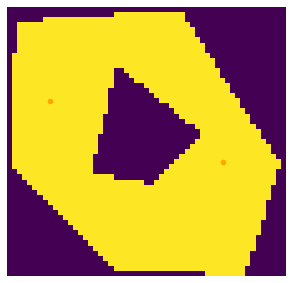

In [10]:
side = 25

# 1 meter scale per pixel
scale = get_scale(final_coverage_polygon, meter=1)
area_map_,mn,mx,sh = get_raster(gpdf_final, scale)
points_, types = coo_to_points(gpdf_points, mn, mx, scale=scale)
# send each point through this.
def retransformer(coverage_path):
    return ((np.array(coverage_path)*side)*mx/scale)+mn[None,None,:] + 1e-4
print(side, mx,mn, scale)

# Downsampling to drone coverage area
area_map, points = down_sample(side, area_map_, points_)
imshow(area_map)
print(area_map.shape)
imshow_scatter(points[0])
imshow_scatter(points[1])

In [11]:
def plot(cp):
    cp = np.array(cp)
    x,y = cp.T
    plt.plot(y,x)
    
# send each point through this.


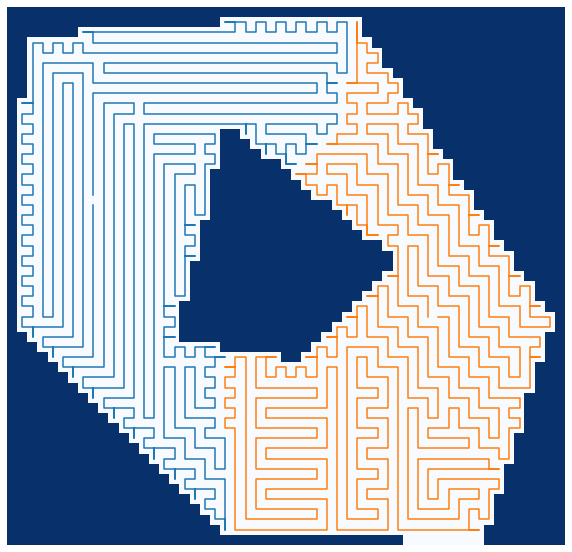

In [12]:
coverage_path_ = cpp(area_map, [*points[0],*points[1]], pbar=True)
coverage_path = list(map(retransformer, coverage_path_[0]))
imshow(area_map,figsize=(10,10), cmap="Blues_r")

plot(coverage_path_[0][0])
plot(coverage_path_[0][1])

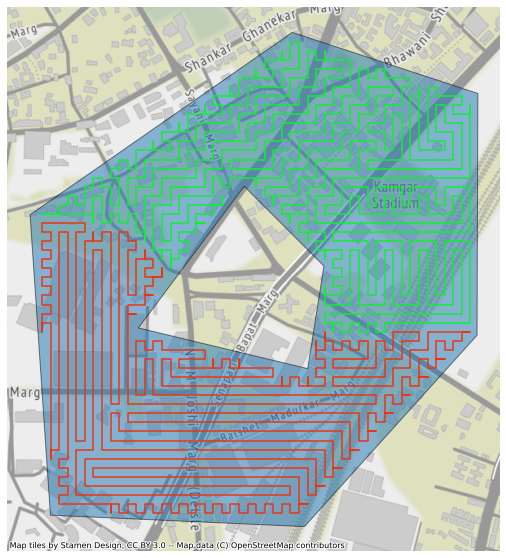

In [13]:
# paths = coords_to_points(coverage_path)
paths = coords_to_points(coverage_path)

epsg = 3857
# epsg = EPSG
bounds = list(gpdf_final.to_crs(epsg=3857).bounds.iloc[0])
ax = gpdf_final.to_crs(epsg=epsg).plot(figsize=(10,10), alpha=0.5, edgecolor='k')
# ax = gpdf_points.to_crs(epsg=epsg).plot(ax=ax)
ax = paths[0].to_crs(epsg=epsg).plot(ax=ax, edgecolor='#ee3311',alpha=1)
ax = paths[1].to_crs(epsg=epsg).plot(ax=ax, edgecolor='#11ee33',alpha=1)
cx.add_basemap(ax=ax)
ax.set_axis_off()

In [14]:
shf = read_shapefile("./sandbox/mapme_1.zip")

In [15]:
features = get_features_dict(shf)
gpdf_final = create_gdframe(features, no_points=True)
final_coverage_polygon = gpdf_final.geometry[0]
gpdf_points = shf[1]
gpdf_points = gpdf_points.set_crs(epsg=EPSG)
width, height = get_hv_wh(final_coverage_polygon)

In [16]:
gpdf_points

,marker-c,marker-s,type,geometry
0,#7e7e7e,0,drone,POINT (72.79987 18.95386)
1,#7e7e7e,0,drone,POINT (72.84039 19.01473)
2,#7e7e7e,0,fuel ...,POINT (72.81790 18.98357)


In [17]:
coo_to_points(gpdf_points, mn, mx, scale=scale)

([[(-2956, -5435), (1527, 1302)], [(-961, -2146)]],
 ['drone',
  'fuel                                                                                                                                                                                                                                                         \x1a'])

2911
(1572, 2911)
[72.79214859 18.92008994] 0.10519347914036459 2911 (63, 117) 2 (1572, 2911) 25.0
(63, 117)


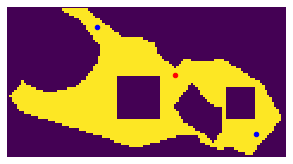

In [32]:
side = 100
# 1 meter scale per pixel
meter = 4
scale = get_scale(final_coverage_polygon, meter=meter)
print(scale)
area_map_,mn,mx,sh = get_raster(gpdf_final, scale)
print(area_map_.shape)
points_, types = coo_to_points(gpdf_points, mn, mx, scale=scale)
st = side/meter

# Downsampling to drone coverage area
area_map, points = down_sample(side, area_map_, points_, meter=meter)
imshow(area_map)

print(mn, mx, scale, area_map.shape, 2, area_map_.shape, st)
def retransformer(coverage_path):
    return ((np.array(coverage_path)*side)*mx/scale)+mn[None,None,:] + 1e-4

print(area_map.shape)
imshow_scatter(points[0],color='blue')
imshow_scatter(points[1],color='red')

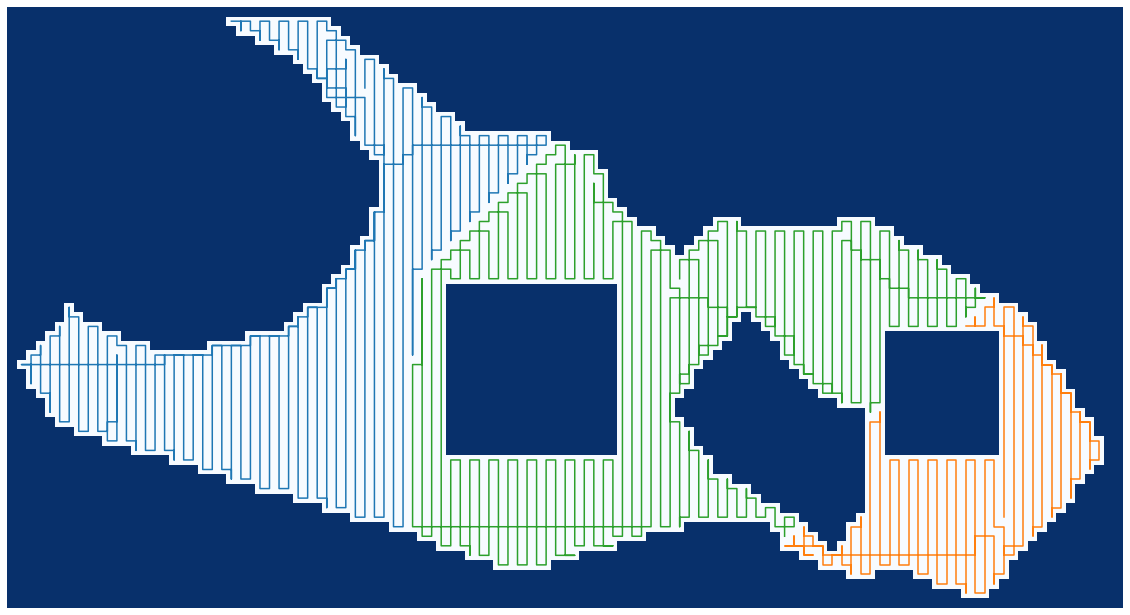

In [30]:
coverage_path_ = cpp(area_map, [*points[0],*points[1]], pbar=True, online=True, drone_coverage=np.array([1,1,0.7]), drone_speed=np.array([0.7,0.3,1]))
coverage_path = list(map(lambda cp:((np.array(cp)*side)*mx/scale)+mn[None,None,:], coverage_path_[0]))
imshow(area_map,figsize=(20,20), cmap="Blues_r")
plot(coverage_path_[0][0])
plot(coverage_path_[0][1])
plot(coverage_path_[0][2])

In [26]:
str(temp)

"[[{'lat': 18.953516247472024, 'lng': 72.7993758988574}, {'lat': 18.953516247472024, 'lng': 72.79847248526121}, {'lat': 18.953516247472024, 'lng': 72.79756907166504}, {'lat': 18.953516247472024, 'lng': 72.79666565806885}, {'lat': 18.954419661068215, 'lng': 72.79666565806885}, {'lat': 18.954419661068215, 'lng': 72.79756907166504}, {'lat': 18.954419661068215, 'lng': 72.79847248526121}, {'lat': 18.954419661068215, 'lng': 72.7993758988574}, {'lat': 18.954419661068215, 'lng': 72.8002793124536}, {'lat': 18.954419661068215, 'lng': 72.80118272604979}, {'lat': 18.954419661068215, 'lng': 72.80208613964598}, {'lat': 18.954419661068215, 'lng': 72.80298955324217}, {'lat': 18.954419661068215, 'lng': 72.80389296683836}, {'lat': 18.954419661068215, 'lng': 72.80479638043455}, {'lat': 18.954419661068215, 'lng': 72.80569979403074}, {'lat': 18.955323074664403, 'lng': 72.80569979403074}, {'lat': 18.955323074664403, 'lng': 72.80479638043455}, {'lat': 18.955323074664403, 'lng': 72.80389296683836}, {'lat': 18

In [23]:
temp = []
for cp in coverage_path:
    temp.append(list(map(lambda x:{'lat':x[1],'lng':x[0]}, cp.reshape(-1,2))))
    

In [35]:
coverage_path = list(map(lambda cp:((np.array(cp)*side)*mx/(scale*meter))+mn[None,None,:], coverage_path_[0]))

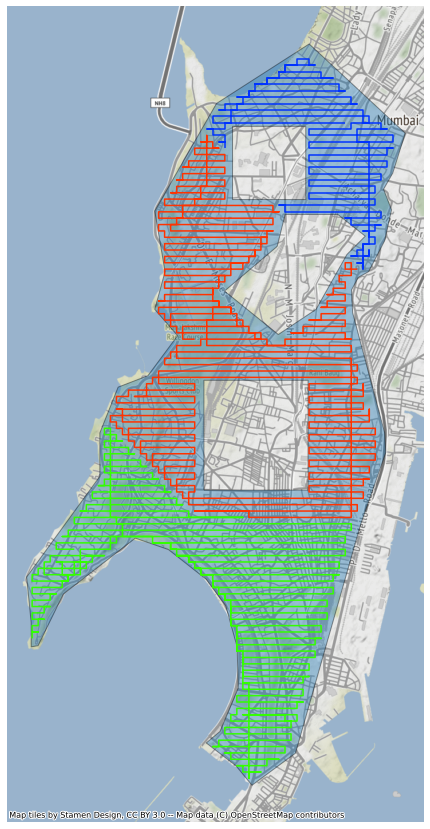

In [36]:
paths = coords_to_points(coverage_path)
paths = coords_to_points(map(lambda cp:cp,coverage_path))

epsg = 3857
conv_crs = f"EPSG:{epsg}"
# epsg = EPSG
bounds = list(gpdf_final.to_crs(epsg=3857).bounds.iloc[0])
ax = gpdf_final.to_crs(epsg=epsg).plot(figsize=(10,15), alpha=0.4, edgecolor='k')
# ax = gpdf_points.to_crs(epsg=epsg).plot(ax=ax)
ax = paths[0].to_crs(epsg=epsg).plot(ax=ax, edgecolor='#33ff00',alpha=1)
ax = paths[1].to_crs(epsg=epsg).plot(ax=ax, edgecolor='#0033ff',alpha=1)
ax = paths[2].to_crs(epsg=epsg).plot(ax=ax, edgecolor='#ff3300',alpha=1)
cx.add_basemap(ax=ax, crs=conv_crs)
ax.set_axis_off()

In [ ]:
smthn = []
for cp in coverage_path:
    smthn.append(list(map(lambda x:{'lat':x[1], 'lng':x[0]},cp.reshape(-1,2))))